Solar Power Forecasting Using Traditional Methods
=================================================


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from math import sqrt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

## Data Preprocessing
Taking only the dataset from 08:00:00 to 18:00:00  

In [2]:
def parse(x):
    return datetime.strptime(x,'%Y %m %d %H %M')
start = '08:00:00'
end = '18:00:00'
df_train =pd.read_csv('full_data.csv',skiprows=2, parse_dates =[['Year','Month','Day','Hour','Minute']], index_col=0, date_parser=parse)
df_train.index.name='date'
df_train = df_train.drop(['DHI','DNI','Clearsky DHI','Clearsky DNI','Clearsky GHI','Precipitable Water','Fill Flag','Cloud Type'],axis = 1)
df_train = df_train.iloc[:,:8]
df_train.columns = ['ghi', 'dew','temp','press','rel_humid', 'zenith_ang','wnd_dir','wnd_spd']
df_train=df_train[['dew','temp','press','rel_humid', 'zenith_ang','wnd_dir','wnd_spd','ghi']]
df_train = df_train.between_time(start, end)

#df_train = df_train[df_train.ghi != 0]
# scaler = MinMaxScaler(feature_range=(0,1))
# df_train = pd.DataFrame(scaler.fit_transform(df_train))

df_train.columns = ['dew','temp','press','rel_humid', 'zenith_ang','wnd_dir','wnd_spd','ghi']
# df_train = pd.concat([df_train['index'],df_train['ghi']],axis = 1)
df_train = df_train['ghi']

## Plotting the dataset


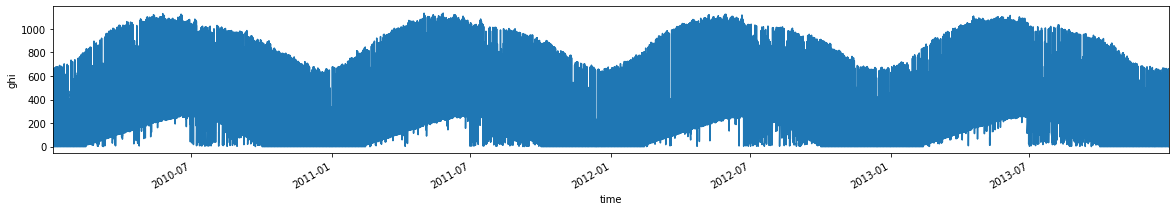

In [3]:
plt.rcParams["figure.figsize"] = (20,3)
df_train.plot()
plt.ylabel('ghi')
plt.xlabel('time')
plt.show()

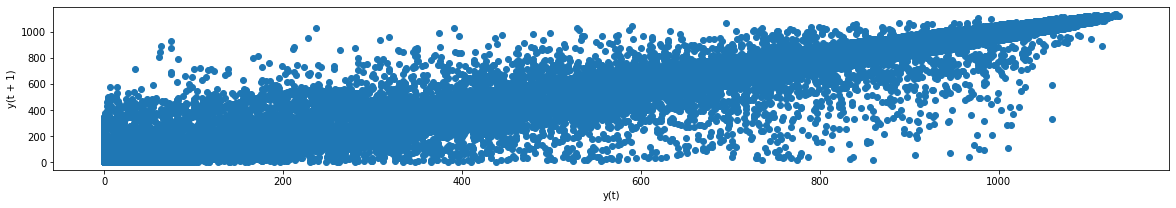

In [5]:
#correlation between ghi(t+1) and ghi(t)
lag_plot(df_train)
plt.show()

* **Pearson Correlation Coefficient** 

In [6]:
#pearson correlation coefficient 
values = pd.DataFrame(df_train.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.914888
t+1  0.914888  1.000000


* **Autocorrelation plots**

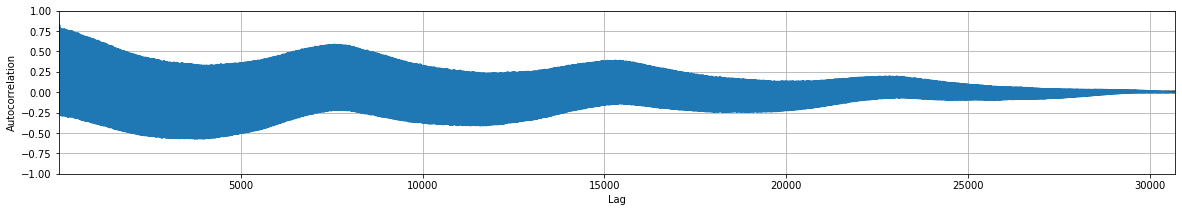

In [7]:
#Autocorrelation plots
autocorrelation_plot(df_train)
plt.show()

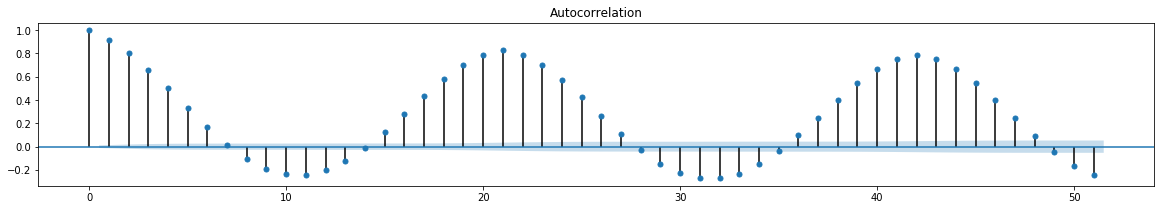

In [8]:
plot_acf(df_train, lags=51)
plt.show()

## Various Methods used for Forecasting

### Persistence Model 
    

Test RMSE: 65.241


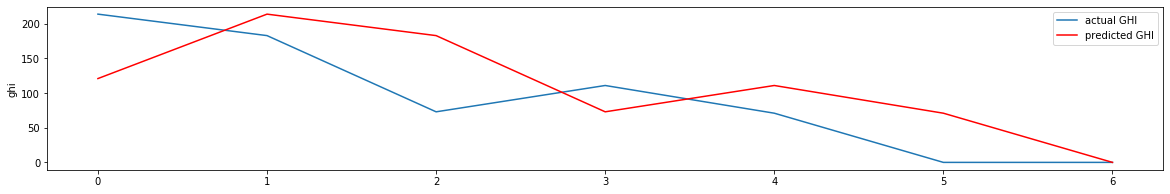

In [9]:
#persistence model
# create lagged dataset
values = pd.DataFrame(df_train.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y,label = 'actual GHI')
plt.plot(predictions,color='red',label = 'predicted GHI')
plt.legend(loc='best')
plt.ylabel('ghi')
plt.show()

### Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

Lag: 50
Coefficients: [ 1.82994570e+01  7.25439911e-01  5.84236851e-02  1.84191915e-02
  2.11735934e-02 -2.46661722e-04 -9.60666581e-03 -5.49250366e-03
  2.58448929e-04 -2.13839992e-03  5.97523088e-03 -7.93806093e-04
  7.41099158e-03 -2.00085418e-02  1.35433834e-02 -7.44271786e-03
  9.80129068e-03 -1.97920041e-02  4.14319516e-02  3.49088135e-02
  5.01792824e-02  1.78559552e-01 -9.38024315e-02 -4.29672694e-02
 -1.82565797e-02 -7.25506479e-03  2.35211318e-03 -3.05773152e-02
  1.45299213e-03  8.89152575e-03 -1.81225327e-02  1.53513115e-03
 -6.13664017e-04  3.48767467e-04  2.02268121e-03 -5.95213234e-03
  1.23284331e-02 -7.68095580e-03  8.42046766e-03  1.95191219e-03
  8.37089382e-03  3.39654966e-02  1.77712230e-01 -9.81513153e-02
 -3.71281597e-02 -1.93320003e-02 -2.05274982e-02 -9.01467778e-03
  2.07869347e-02 -1.43501881e-03 -3.02123194e-03]
predicted=104.357732, expected=214.000000
predicted=83.637435, expected=183.000000
predicted=65.857346, expected=73.000000
predicted=59.622631, expe

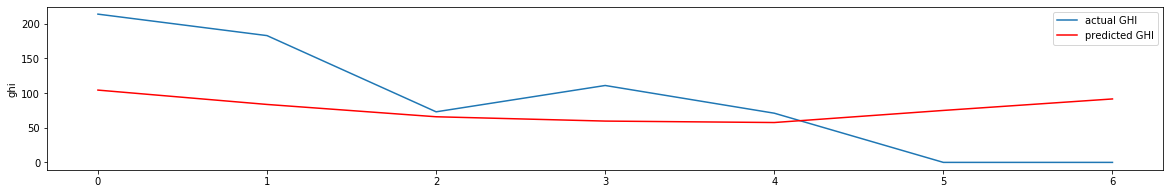

In [10]:
# split dataset
X = df_train.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot results
plt.plot(test,label = 'actual GHI')
plt.plot(predictions,color='red',label = 'predicted GHI')
plt.legend(loc='best')
plt.ylabel('ghi')
plt.show()

 Auto regression prediction by using forecasted value as input for next prediction

predicted=104.357732, expected=214.000000
predicted=163.176312, expected=183.000000
predicted=144.344622, expected=73.000000
predicted=72.628847, expected=111.000000
predicted=99.384599, expected=71.000000
predicted=89.965573, expected=0.000000
predicted=37.973839, expected=0.000000
Test RMSE: 64.717


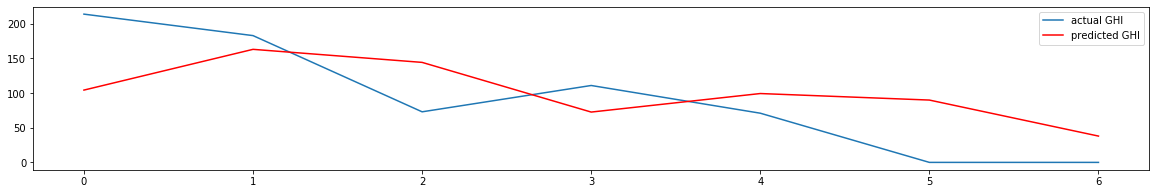

In [16]:
# split dataset
X = df_train.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test,label = 'actual GHI')
plt.plot(predictions,color='red',label = 'predicted GHI')
plt.legend(loc='best')
plt.show()

### ARIMA model
 * **Grid Search for optimum p,d,q values**

In [17]:
def evaluate_arima_model(X, arima_order):
    # prepare training and test dataset
    train_size = int(len(X) * 0.9999)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = sqrt(evaluate_arima_model(dataset, order))
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

#grid search for optimum p,d,q values 
p_values = [1, 2, 3,5]
d_values = range(0,3)
q_values = [0]
evaluate_models(df_train.values, p_values, d_values, q_values)

ARIMA(1, 0, 0) RMSE=71.419
ARIMA(1, 1, 0) RMSE=48.908
ARIMA(1, 2, 0) RMSE=70.276
ARIMA(2, 0, 0) RMSE=75.602
ARIMA(2, 1, 0) RMSE=48.713
ARIMA(2, 2, 0) RMSE=38.875
ARIMA(3, 0, 0) RMSE=79.778
ARIMA(3, 1, 0) RMSE=43.303
ARIMA(3, 2, 0) RMSE=50.062
ARIMA(5, 0, 0) RMSE=88.411
ARIMA(5, 1, 0) RMSE=40.981
ARIMA(5, 2, 0) RMSE=47.075
Best ARIMA(2, 2, 0) RMSE=38.875


* **Using optimum p,d,q values for prediction **

predicted=104.286620, expected=214.000000
predicted=214.479327, expected=183.000000
predicted=175.793215, expected=73.000000
predicted=64.273744, expected=111.000000
predicted=104.905284, expected=71.000000
predicted=57.091692, expected=0.000000
predicted=-11.192552, expected=0.000000
Test RMSE: 65.805


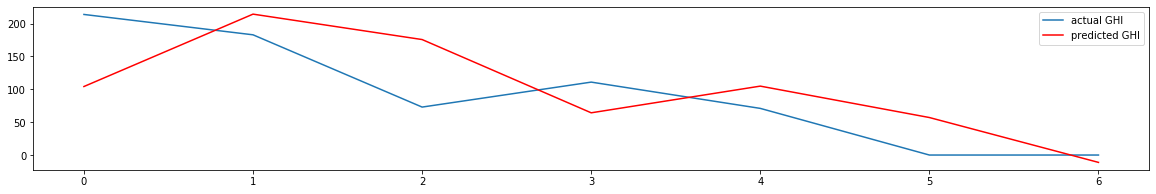

In [18]:
# ARIMA model
X = df_train.values
size = int(len(X) * 0.9998)
train, test = X[0:size], X[size:len(X)]
history = [float(x) for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test,label = 'actual GHI')
plt.plot(predictions,color='red',label = 'predicted GHI')
plt.legend(loc='best')
plt.show()